Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data

### Importing all the important libraries

In [1]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

The dataset comprises of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [2]:
# Defining the path for train and test images
data_dir_train = pathlib.Path(os.path.join("Skin cancer ISIC The International Skin Imaging Collaboration", "Train"))
data_dir_test = pathlib.Path(os.path.join("Skin cancer ISIC The International Skin Imaging Collaboration", "Test"))

In [3]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Creating a dataset

Defining some parameters for the loader:

In [4]:
batch_size = 32
img_height = 180
img_width = 180

Using 80% of the images for training, and 20% for validation.

In [5]:
train_ds, val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    labels='inferred',
    label_mode='categorical',
    class_names=None,
    color_mode='rgb',
    batch_size=batch_size,
    image_size=(img_height, img_width),
    seed=123,
    validation_split=0.2,
    subset='both',
    interpolation='bilinear',
    follow_links=False,
    crop_to_aspect_ratio=False,
    pad_to_aspect_ratio=False,
    data_format=None,
    verbose=True
)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.
Using 1347 files for validation.


In [6]:
print(train_ds)
print(val_ds)

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 180, 180, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 9), dtype=tf.float32, name=None))>
<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 180, 180, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 9), dtype=tf.float32, name=None))>


In [7]:
# Listing out all the classes of skin cancer.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### Visualizing one instance of all the nine classes present in the dataset

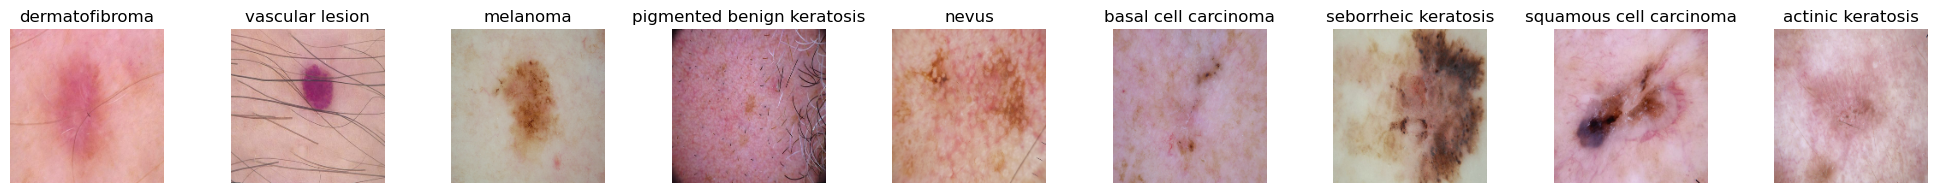

In [8]:
import matplotlib.pyplot as plt

examples_per_class = {}

for image, labels in train_ds.unbatch():
    class_index = tf.argmax(labels).numpy()
    class_name = class_names[class_index]
    
    if class_name not in examples_per_class:
        examples_per_class[class_name] = image
    
    if len(examples_per_class) == len(class_names):
        break

idx = 0
fig, axs = plt.subplots(1, 9, figsize=(20, 2))

for class_name, image in examples_per_class.items():
    # print(f"Class: {class_name}, Image: {image.numpy()}")
    axs[idx].imshow(image.numpy().astype('uint8'))
    axs[idx].set_title(class_name)
    axs[idx].axis('off')
    idx += 1

plt.tight_layout()
plt.show()

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [9]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Creating the model

In [35]:
model = tf.keras.Sequential([
    layers.Rescaling(scale = 1./255, input_shape = (180,180,3)),
    layers.Conv2D(16, 3, padding='same', activation= 'relu'),
    layers.MaxPooling2D(pool_size = 2, strides = 2),    
    layers.Conv2D(32, 3, padding='same', activation= 'relu'),
    layers.MaxPooling2D(pool_size = 2, strides = 2),
    layers.Conv2D(64, 3, padding='same', activation= 'relu'),
    layers.MaxPooling2D(pool_size = 2, strides = 2),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(len(class_names))
])

C:\Users\KASH\anaconda3\Lib\site-packages\keras\src\layers\preprocessing\tf_data_layer.py:18: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


### Compiling the model 

Using Adam Optimiser and CategoricalCrossentropy Loss Function for model training.

In [36]:
model.compile(optimizer=keras.optimizers.Adam(),
              loss=tf.losses.CategoricalCrossentropy(from_logits = True),
              metrics=['accuracy'])

In [37]:
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling_3 (Rescaling)              │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 180, 180, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (None, 90, 90, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 90, 90, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_10 (MaxPooling2D)      │ (None, 45, 45, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 45, 45, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_11 (MaxPooling2D)      │ (None, 22, 22, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 30976)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 128)                 │       3,965,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 9)                   │           1,161 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,989,801 (15.22 MB)

 Trainable params: 3,989,801 (15.22 MB)

 Non-trainable params: 0 (0.00 B)

### Training the model

In [38]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 39s 505ms/step - accuracy: 0.1621 - loss: 2.2984 - val_accuracy: 0.1924 - val_loss: 2.0348
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 15s 271ms/step - accuracy: 0.2291 - loss: 2.0189 - val_accuracy: 0.2685 - val_loss: 1.9194
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 14s 244ms/step - accuracy: 0.2987 - loss: 1.8710 - val_accuracy: 0.3423 - val_loss: 1.8260
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 14s 249ms/step - accuracy: 0.3815 - loss: 1.7273 - val_accuracy: 0.5011 - val_loss: 1.4684
Epoch 5/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 17s 305ms/step - accuracy: 0.4812 - loss: 1.4649 - val_accuracy: 0.5436 - val_loss: 1.4233
Epoch 6/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 15s 263ms/step - accuracy: 0.5469 - loss: 1.3065 - val_accuracy: 0.5011 - val_loss: 1.4321
Epoch 7/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 15s 261ms/step - accuracy: 0.5429 - loss: 1.2675 - val_accuracy: 0.5526 - val_loss: 1.3288
Epoch 8/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 14s 258ms/step - accuracy: 0.6012 - loss: 1.1209 - val_accu

### Visualizing training results

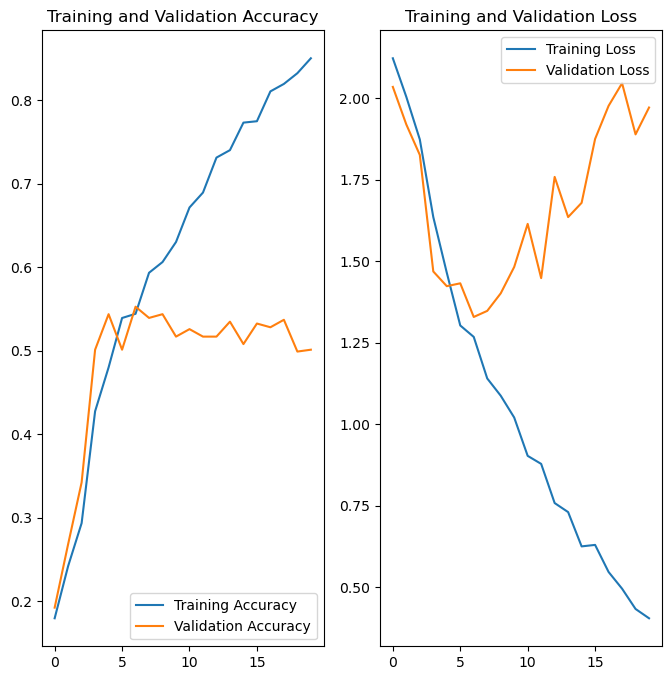

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Findings -

Model is clearly overfitting because of below reasons

- After 20 epochs, training accuracy is 0.87, but validation accuracy is only 0.56.
- Training loss decreases consistently, while validation loss increases after the 5th epoch.
- The model memorizes the training data instead of generalizing, leading to poor validation performance.

In [14]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal_and_vertical", input_shape=(img_height, img_width, 3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

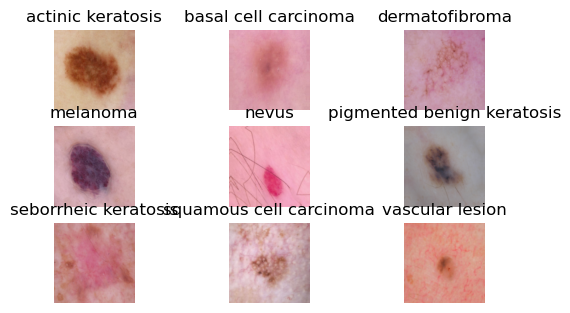

In [15]:
for img, labels in train_ds.take(1):
    for i in range(9):
        ax=plt.subplot(4, 3, i+1)
        plt.imshow(data_augmentation(img)[i].numpy().astype('uint8'))
        plt.title(class_names[i])
        plt.axis("off")

### Creating the model


In [16]:
## Using Dropout layer as there is an evidence of overfitting in the findings

model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(len(class_names))
])


### Compiling the model

In [17]:
model.compile(optimizer=keras.optimizers.Adam(),
              loss=tf.losses.CategoricalCrossentropy(from_logits = True),
              metrics=['accuracy'])

### Training the model

In [28]:
## Your code goes here, note: train your model for 20 epochs
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 16s 243ms/step - accuracy: 0.2204 - loss: 2.2008 - val_accuracy: 0.3557 - val_loss: 1.8349
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 15s 262ms/step - accuracy: 0.3537 - loss: 1.7418 - val_accuracy: 0.4004 - val_loss: 1.6856
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 14s 247ms/step - accuracy: 0.4143 - loss: 1.6349 - val_accuracy: 0.4362 - val_loss: 1.5488
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 13s 230ms/step - accuracy: 0.4446 - loss: 1.5608 - val_accuracy: 0.4586 - val_loss: 1.4918
Epoch 5/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 13s 230ms/step - accuracy: 0.4714 - loss: 1.4483 - val_accuracy: 0.5302 - val_loss: 1.3971
Epoch 6/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 14s 254ms/step - accuracy: 0.5009 - loss: 1.3932 - val_accuracy: 0.4855 - val_loss: 1.4858
Epoch 7/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 17s 301ms/step - accuracy: 0.5013 - loss: 1.4059 - val_accuracy: 0.5101 - val_loss: 1.4272
Epoch 8/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 17s 296ms/step - accuracy: 0.5353 - loss: 1.2932 - val_accu

### Visualizing the results

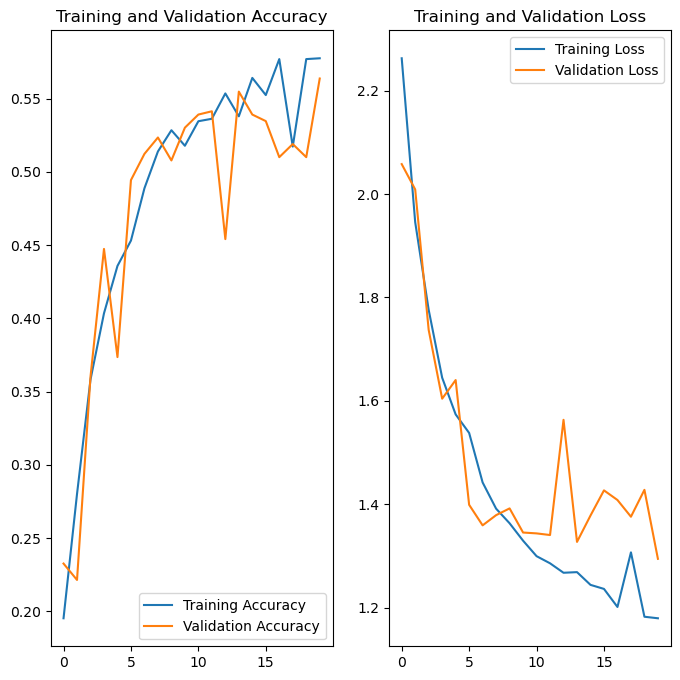

In [18]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Findings:
- No evidence of overfitting: training and validation accuracies are close (0.58, 0.54).
- Evidence of underfitting: both accuracies are low (<0.6).
- Image augmentation reduced overfitting, leading to improved model accuracy and synchronized training and validation losses.

#### Distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [19]:
from glob import glob
path_list = [x for x in glob(os.path.join(data_dir_train, '*', '*.jpg'))]
lesion_list = [os.path.basename(os.path.dirname(y)) for y in glob(os.path.join(data_dir_train, '*', '*.jpg'))]
dataframe_dict = dict(zip(path_list, lesion_list))
original_df = pd.DataFrame(list(dataframe_dict.items()),columns = ['Path','Label'])
original_df['Label'].value_counts()

Label
pigmented benign keratosis    462
melanoma                      438
basal cell carcinoma          376
nevus                         357
squamous cell carcinoma       181
vascular lesion               139
actinic keratosis             114
dermatofibroma                 95
seborrheic keratosis           77
Name: count, dtype: int64

#### Findings: 
#### - Which class has the least number of samples?
- seborrheic keratosis
#### - Which classes dominate the data in terms proportionate number of samples?
- pigmented benign keratosis, melanoma, basal cell carcinoma, nevus

#### Rectifying the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [31]:
!pip install Augmentor

  Obtaining dependency information for Augmentor from https://files.pythonhosted.org/packages/f3/86/5a91176650eb229ea2cd95551c34c36fba6cd95da3bdc4a5c73fbb1536ca/Augmentor-0.2.12-py2.py3-none-any.whl.metadata


To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [32]:
path_to_training_dataset=str(data_dir_train) + '/'
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration\Train/actinic keratosis\output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x16CC8585250>: 100%|█| 500/500 [00:04<00:


Initialised with 376 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration\Train/basal cell carcinoma\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x16CC83BB690>: 100%|█| 500/500 [00:04<00:00, 111.43 Samples


Initialised with 95 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration\Train/dermatofibroma\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x16CC81E3250>: 100%|█| 500/500 [00:04<00:00, 102.79 Samples


Initialised with 438 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration\Train/melanoma\output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x16CC81BB950>: 100%|█| 500/500 [00:28<00:00, 17.53 Samples


Initialised with 357 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration\Train/nevus\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x16CC6FD0850>: 100%|█| 500/500 [00:28<00:00, 17.76 Samples/


Initialised with 462 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration\Train/pigmented benign keratosis\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x16CC904D890>: 100%|█| 500/500 [00:06<00:00, 81.97 Samples/


Initialised with 77 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration\Train/seborrheic keratosis\output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x16CC81B9BD0>: 100%|█| 500/500 [00:14<00:00, 34.67 Samples


Initialised with 181 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration\Train/squamous cell carcinoma\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x16CC6F77C10>: 100%|█| 500/500 [00:05<00:00, 84.98 Samples/


Initialised with 139 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration\Train/vascular lesion\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x16CC6F92450>: 100%|█| 500/500 [00:05<00:00, 85.79 Samples/


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [20]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Distribution of augmented data after adding new images to the original training data.

In [21]:
path_list_new = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list_new

['Skin cancer ISIC The International Skin Imaging Collaboration\\Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025780.jpg_14465015-58c2-4d58-b862-115dba7ae74c.jpg',
 'Skin cancer ISIC The International Skin Imaging Collaboration\\Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025780.jpg_28940db1-7a05-4a8f-ab86-a573bc149d7c.jpg',
 'Skin cancer ISIC The International Skin Imaging Collaboration\\Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025780.jpg_31497755-3eed-4878-aad3-f19cc900d731.jpg',
 'Skin cancer ISIC The International Skin Imaging Collaboration\\Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025780.jpg_6bef2fe3-b149-47c1-99b8-3d875d1c49fc.jpg',
 'Skin cancer ISIC The International Skin Imaging Collaboration\\Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025780.jpg_7e624d00-e9aa-4bf5-ad1b-4644a9793dd4.jpg',
 'Skin cancer ISIC The International Skin Imaging Collaboration\\Train

In [22]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic 

In [23]:
dataframe_dict_new = dict(zip(path_list_new, lesion_list_new))

In [24]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
# new_df = original_df.append(df2)
new_df = pd.concat([original_df, df2], ignore_index=True)

In [25]:
new_df['Label'].value_counts()

Label
pigmented benign keratosis    962
melanoma                      938
basal cell carcinoma          876
nevus                         857
squamous cell carcinoma       681
vascular lesion               639
actinic keratosis             614
dermatofibroma                595
seborrheic keratosis          577
Name: count, dtype: int64

In [26]:
new_df.shape

(6739, 2)

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### Training the model on the data created using Augmentor

In [27]:
batch_size = 32
img_height = 180
img_width = 180

#### Creating a training dataset

In [28]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'training',
  image_size=(img_height, img_width),
  batch_size=batch_size,
  verbose=True)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


#### Creating a validation dataset

In [29]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',
  image_size=(img_height, img_width),
  batch_size=batch_size,
  verbose=True)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


#### Creating the model (including normalization)

In [30]:
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(len(class_names))
])

#### Compiling the model

In [31]:
model.compile(optimizer=keras.optimizers.Adam(),
              loss=tf.losses.SparseCategoricalCrossentropy(from_logits = True),
              metrics=['accuracy'])

#### Training the model

In [33]:
epochs = 50

history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 66s 364ms/step - accuracy: 0.2519 - loss: 1.9859 - val_accuracy: 0.4076 - val_loss: 1.5469
Epoch 2/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 59s 346ms/step - accuracy: 0.4138 - loss: 1.5265 - val_accuracy: 0.4692 - val_loss: 1.3798
Epoch 3/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 59s 348ms/step - accuracy: 0.4659 - loss: 1.4095 - val_accuracy: 0.4840 - val_loss: 1.3403
Epoch 4/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 58s 343ms/step - accuracy: 0.4989 - loss: 1.3264 - val_accuracy: 0.4989 - val_loss: 1.3239
Epoch 5/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 60s 355ms/step - accuracy: 0.5049 - loss: 1.2776 - val_accuracy: 0.5256 - val_loss: 1.2709
Epoch 6/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 60s 352ms/step - accuracy: 0.5184 - loss: 1.2476 - val_accuracy: 0.5494 - val_loss: 1.2096
Epoch 7/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 60s 352ms/step - accuracy: 0.5499 - loss: 1.1621 - val_accuracy: 0.5278 - val_loss: 1.2380
Epoch 8/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 58s 342ms/step - accuracy: 0.5704 - loss: 1

#### Visualizing the model results

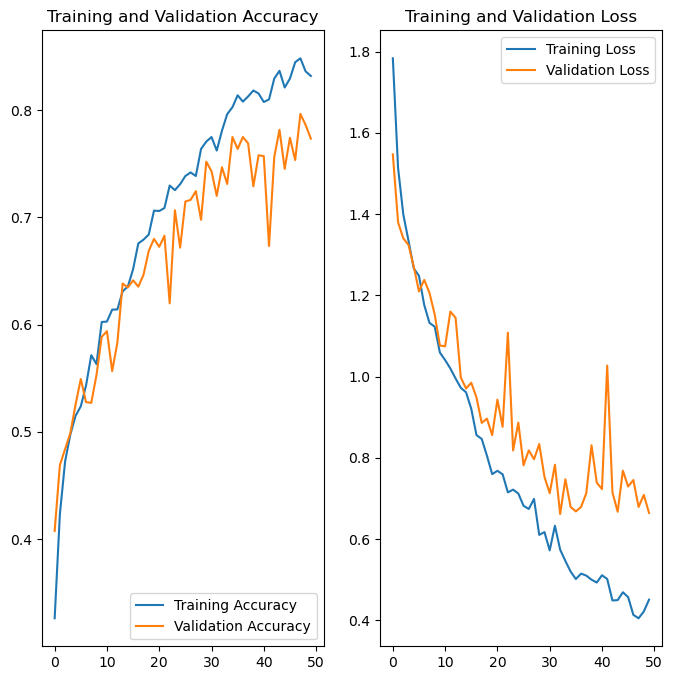

In [34]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Result Analysis:

- 1st Model - Overfitting was evident as difference between Training accuracy and Validation Accuracy was large.
- 2nd Model - After geting rid of overfitting and training our model, we witnessed that gap between training and validation accuracy was closed, but underfitting became evident as both Training and Validation accuracy was lower (< 0.5).
- 3rd Model - After using class rebalancing, we are able to get rid of underfitting as our latest model's Training and Validation accuracy has significantly improved (> 0.7) [Training Accuracy - 0.83, Validation Accuracy - 0.77]  

# END